# RSCS for 2D signals

Domingo, Kenneth V.<br />
2015-03116<br />
Video and Image Processing Group<br />
Instrumentation Physics Laboratory

In [3]:
!pip install --upgrade pip

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 1.4 MB/s eta 0:00:0000:0100:010m
  Attempting uninstall: pip
    Found existing installation: pip 23.0.1
    Uninstalling pip-23.0.1:
      Successfully uninstalled pip-23.0.1


In [4]:
!pip install cvxpy

In [7]:
!pip install lbfgs

ERROR: Could not find a version that satisfies the requirement lbfgs (from versions: none)
ERROR: No matching distribution found for lbfgs


In [9]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.fftpack as fft
import scipy.ndimage as img
import numpy.random as rd
import sklearn.linear_model as slm
import sklearn.metrics as skm
import cvxpy as cvx
import cv2 as cv
import seaborn as sns
# from lbfgs import fmin_lbfgs
# from jupyterthemes import jtplot
from tqdm.notebook import tqdm, trange
from copy import deepcopy

In [2]:
jtplot.reset()
sns.set()
sns.set_context('talk')
mp.rcParams["figure.figsize"] = (5, 5)
mp.rcParams["figure.dpi"] = 100
rd.seed(314)

In [10]:
def dct2(x):
    return fft.dct(fft.dct(x.T, norm='ortho', axis=0).T, norm='ortho', axis=0)

def idct2(x):
    return fft.idct(fft.idct(x.T, norm='ortho', axis=0).T, norm='ortho', axis=0)

Optimization objective for LASSO:

\begin{equation}
    \frac{1}{2n_{samples}} ||y - Xw||_2^2 + \alpha ||w||_1
\end{equation}

## Test 2D sine signal

In [11]:
N = 50
t = np.linspace(-4*np.pi,4*np.pi,N)
X,Y = np.meshgrid(t,t)

sigx = np.sin(X)
sigy = np.sin(Y)
sigd = np.sin(X+Y)
sigp = np.sin(X) + np.sin(Y)
sig = np.array([sigx, sigy, sigd, sigp])

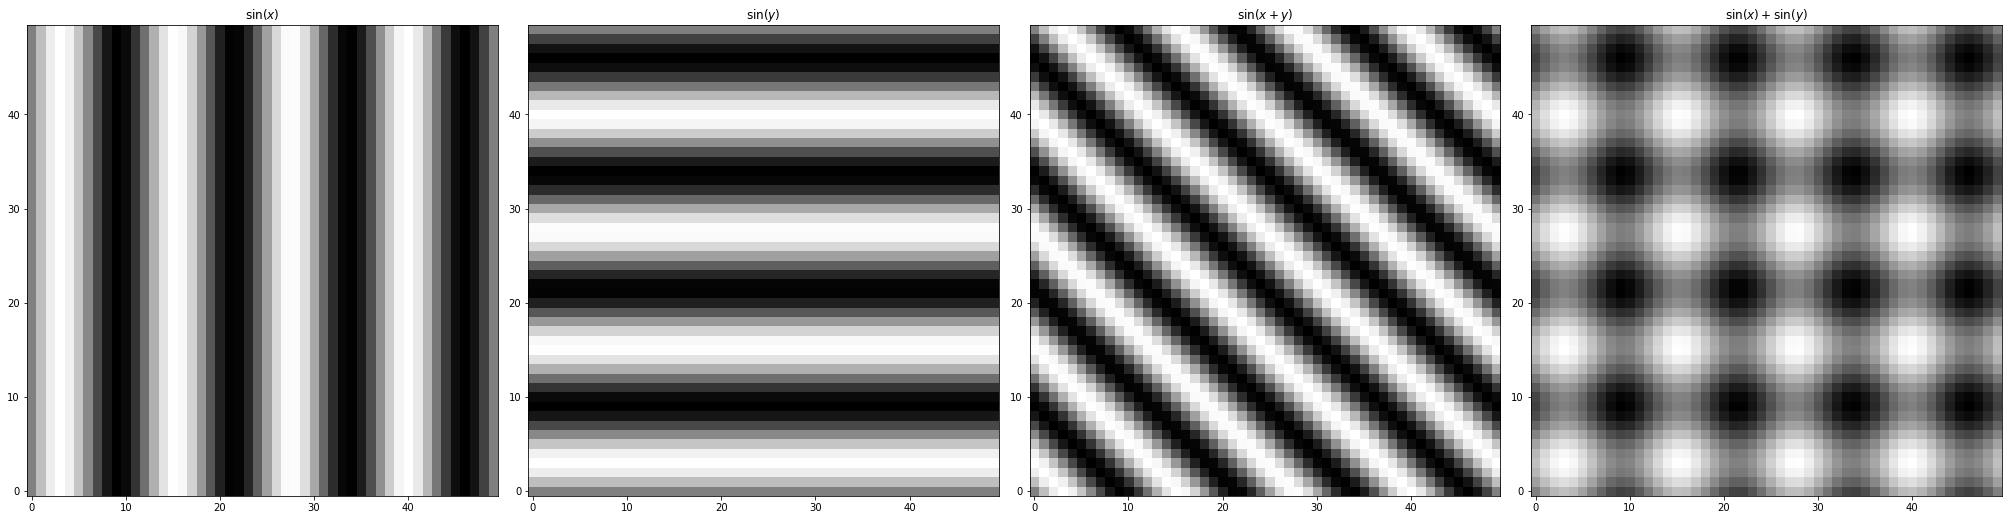

In [12]:
fig,(ax1,ax2,ax3,ax4) = mp.subplots(ncols=4, figsize=(7*4,7))

ax1.imshow(sigx, cmap="gray", origin="lower")
ax1.set_title(r"$\sin(x)$")
ax1.grid(0)

ax2.imshow(sigy, cmap="gray", origin="lower")
ax2.set_title(r"$\sin(y)$")
ax2.grid(0)

ax3.imshow(sigd, cmap="gray", origin="lower")
ax3.set_title(r"$\sin(x+y)$")
ax3.grid(0)

ax4.imshow(sigp, cmap="gray", origin="lower")
ax4.set_title(r"$\sin(x) + \sin(y)$")
ax4.grid(0)

mp.tight_layout()
# mp.savefig("2DCS-1/test.png", dpi=300, bbox_inches="tight")
mp.show()

In [13]:
Xat2 = np.zeros_like(sig, float)
Xat = np.zeros_like(sig, float)
Xa = np.zeros_like(sig, float)
mask = np.zeros_like(sig, float)
Xm = np.zeros_like(sig, float)

In [14]:
for i in range(len(sig)):
    ny, nx = sig[i].shape

    # extract small sample of signal
    extract = 0.05
    k = round(nx * ny * extract)
    ri = rd.choice(nx * ny, k, replace=False) # random sample of indices
    b = sig[i].T.flat[ri]
#     b = np.expand_dims(b, axis=1)

    # create dct matrix operator using kron (memory errors for large ny*nx)
    A = np.kron(fft.idct(np.identity(nx), norm='ortho', axis=0), fft.idct(np.identity(ny), norm='ortho', axis=0))
    A = A[ri,:] # same as phi times kron
    
    # do L1 optimization
    vx = cvx.Variable(nx * ny)
    objective = cvx.Minimize(cvx.norm(vx, 1))
    constraints = [A*vx == b]
    prob = cvx.Problem(objective, constraints)
    result = prob.solve()
    Xat2[i] = np.array(vx.value.reshape(ny, nx))
    Xat2[i] = np.squeeze(Xat2[i])
    
    Xat[i] = Xat2[i].reshape(nx, ny).T # stack columns
    Xa[i] = idct2(Xat[i])

    mask[i] = np.zeros(sig[i].shape)
    mask[i].T.flat[ri] = 255
#     Xm[i] = 255 * np.ones(sig[i].shape)
    Xm[i].T.flat[ri] = sig[i].T.flat[ri]

/opt/anaconda3/lib/python3.9/site-packages/cvxpy/expressions/expression.py:612: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 1 times so far.

  warnings.warn(msg, UserWarning)
/opt/anaconda3/lib/python3.9/site-packages/cvxpy/expressions/expression.py:612: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 2 times so far.

  warnings.warn(msg, UserWarning)
/opt/anaconda3/lib/p

MSE = 3.807566295392496e-18


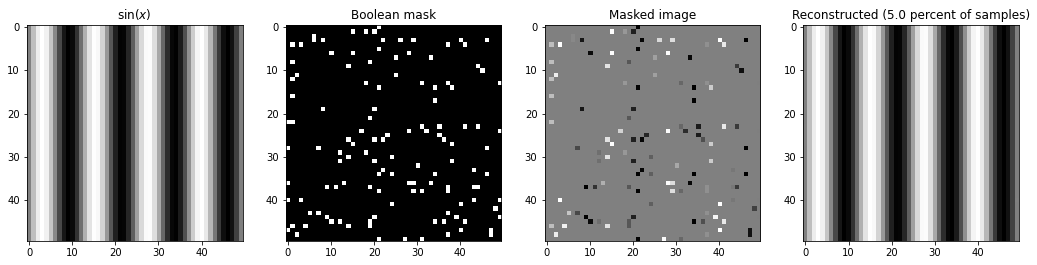

MSE = 8.190537010770156e-05


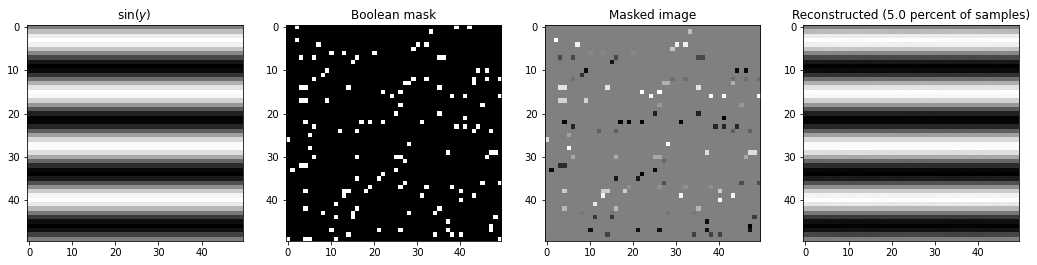

MSE = 0.05809395519353485


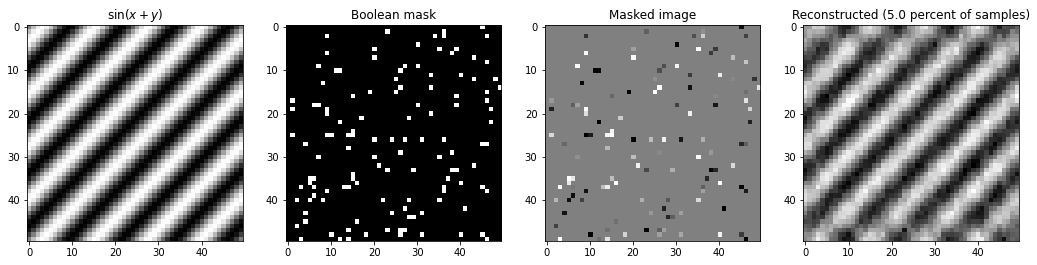

MSE = 0.01509122596159318


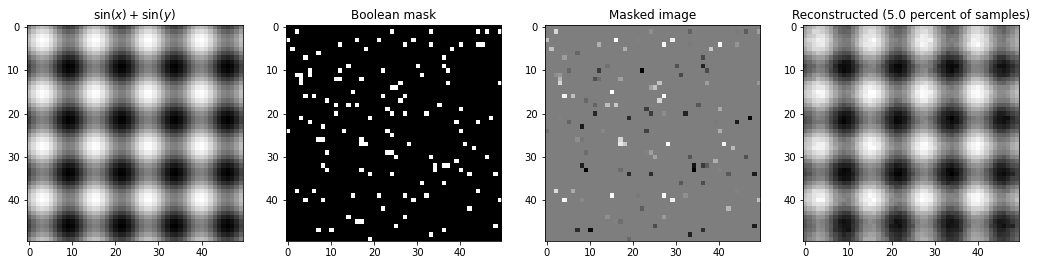

In [15]:
for i in range(len(sig)):
    if i == 0:
        cor = r"$\sin(x)$"
    elif i == 1:
        cor = r"$\sin(y)$"
    elif i == 2:
        cor = r"$\sin(x+y)$"
    else:
        cor = r"$\sin(x) + \sin(y)$"
    
    fig,(ax1,ax2,ax3,ax4) = mp.subplots(ncols=4, figsize=(5*2*16/9,5))

    ax1.imshow(sig[i], cmap="gray", origin="upper")
    ax1.set_title(cor)
    ax1.grid(0)

    ax2.imshow(mask[i], cmap="gray", origin="upper")
    ax2.set_title("Boolean mask")
    ax2.grid(0)
    
    ax3.imshow(Xm[i], cmap="gray", origin="upper")
    ax3.set_title("Masked image")
    ax3.grid(0)
    
    ax4.imshow(Xa[i], cmap="gray", origin="upper")
    ax4.set_title(f"Reconstructed ({extract*100} percent of samples)")
    ax4.grid(0)
    
    fname = "Experiment/2DCS-1/2dsinmask" + cor + ".png"
    err = skm.mean_squared_error(Xa[i], sig[i])
    print(f"MSE = {err}")
#     mp.savefig(fname, dpi=300, bbox_inches="tight")
    mp.show()

## Test with complex image

In [17]:
X_orig = cv.resize(cv.imread("escher_relativity.png", 0), (1600, 976))
ny,nx = X_orig.shape
sec = 16
k = int(X_orig.size * 0.5)
ri = rd.choice(X_orig.size, k, replace=False)
Xm = 255*np.ones(X_orig.shape)
Xm.T.flat[ri] = X_orig.T.flat[ri]

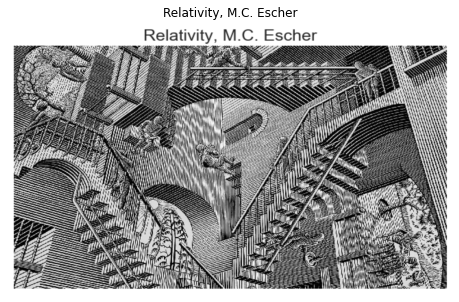

In [18]:
fig,ax = mp.subplots(figsize=(5*16/9, 5))
ax.set_title("Relativity, M.C. Escher")
ax.imshow(X_orig, cmap="gray", origin="upper")

#ax.xaxis.set_major_locator(mp.MultipleLocator(nx//sec))
#ax.yaxis.set_major_locator(mp.MultipleLocator(ny//sec))
#ax.grid(color="r", lw=1.5)
ax.grid(0)
ax.axis('off')

#mp.savefig("d:/kenneth/documents/4-2/vip/progrep1_prev/orig_escher.png", transparent=True, dpi=300, bbox_inches="tight")
mp.show()

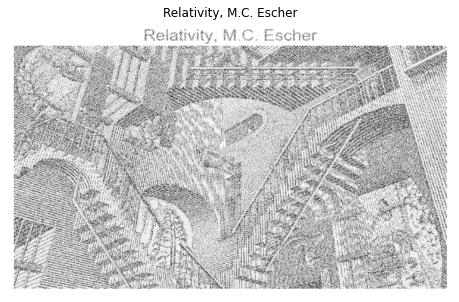

In [19]:
fig,ax = mp.subplots(figsize=(5*16/9, 5))
ax.set_title("Relativity, M.C. Escher")
ax.imshow(Xm, cmap="gray", origin="upper")

#ax.xaxis.set_major_locator(mp.MultipleLocator(nx//sec))
#ax.yaxis.set_major_locator(mp.MultipleLocator(ny//sec))
#ax.grid(color="r", lw=1.5)
ax.grid(0)
ax.axis('off')
#mp.savefig("d:/kenneth/documents/4-2/vip/progrep1_prev/comp_escher.png", transparent=True, dpi=300, bbox_inches="tight")
mp.show()

In [10]:
n = np.arange(sec)
slices = np.zeros((sec,sec), object)
recover = np.zeros((sec,sec), object)
for j in n:
    for i in n:
        slices[j,i] = X_orig[ ny//sec*j:ny//sec*(j+1) , nx//sec*i:nx//sec*(i+1)]

In [16]:
ny,nx = slices[j,i].shape
ex = 0.5
k = np.round(nx * ny * ex).astype(int)
ri = rd.choice(nx * ny, k, replace=False)
A = np.kron(fft.idct(np.identity(nx), norm='ortho', axis=0), fft.idct(np.identity(ny), norm='ortho', axis=0))
A = A[ri,:]

for j in trange(len(slices)):
    for i in trange(len(slices)):
        b = slices[j,i].T.flat[ri]
#         b = np.expand_dims(b, axis=1)

        vx = cvx.Variable(nx * ny)
        objective = cvx.Minimize(cvx.norm(vx, 1))
        constraints = [A*vx == b]
        prob = cvx.Problem(objective, constraints)
        result = prob.solve()
        Xat2 = np.array(vx.value)
        Xat2 = np.squeeze(Xat2)

        Xat = Xat2.reshape(nx, ny).T # stack columns
        Xa = idct2(Xat)
        recover[j,i] = Xa

In [20]:
recovery = np.zeros(len(recover), object)
for i in range(len(recover)):
    recovery[i] = np.concatenate(recover[i,:], axis=1)
recovery = recovery.T

In [21]:
recovery = np.concatenate(recovery[:], axis=0)

In [11]:
recovery = np.load("escher_cvx50.npy").astype('float32')

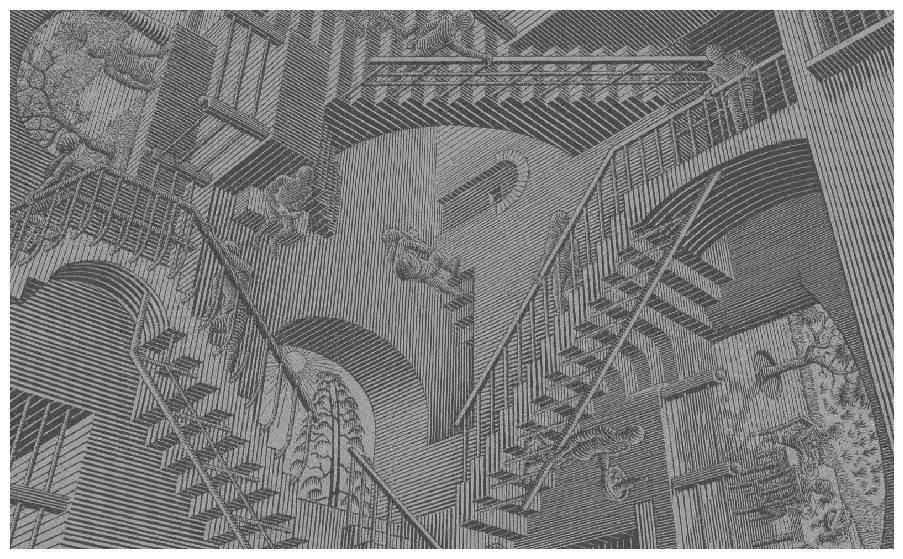

In [12]:
mp.figure(figsize=(7*16/9,7))
mp.imshow(recovery, cmap="gray")
mp.axis('off')
mp.show()

# recovery /= recovery.max()
# recovery = (recovery*255).astype("uint8")
# cv.imwrite("escher_recov50.png", recovery)

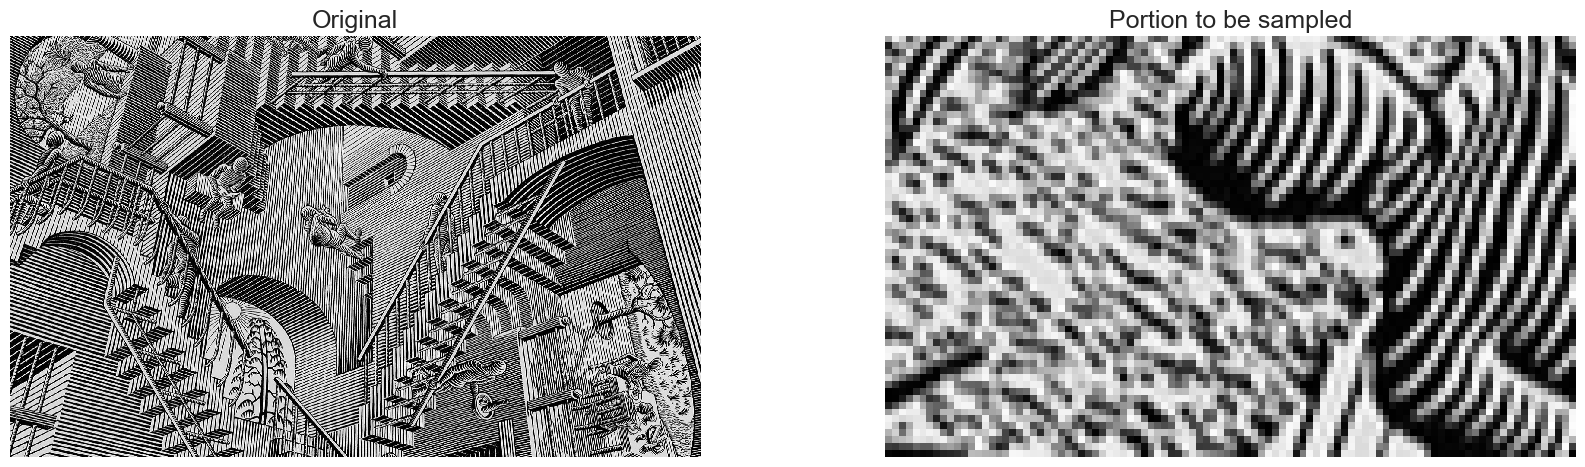

In [13]:
X_slice = X_orig[ ny//sec:ny//sec*2 , nx//sec:nx//sec*2 ]

fig,(ax1,ax2) = mp.subplots(ncols=2, figsize=(5*2*16/9,5))

ax1.imshow(X_orig, cmap="gray", origin="upper")
ax1.set_title(r"Original")
ax1.xaxis.set_major_locator(mp.MultipleLocator(nx//sec))
ax1.yaxis.set_major_locator(mp.MultipleLocator(ny//sec))
ax1.grid(color="r")
ax1.axis('off')

ax2.imshow(X_slice, cmap="gray", origin="upper")
ax2.set_title(r"Portion to be sampled")
ax2.axis('off')

mp.tight_layout()
#mp.savefig("Experiment/2DCS-1/portion.png", dpi=300, bbox_inches="tight")
mp.show()

In [32]:
ny,nx = X_slice.shape
ex = 0.5
k = np.round(nx * ny * ex).astype(int)
ri = rd.choice(nx * ny, k, replace=False) # random sample of indices
b = X_slice.T.flat[ri]

# create dct matrix operator using kron (memory errors for large ny*nx)
A = np.kron(fft.idct(np.identity(nx), norm='ortho', axis=0), fft.idct(np.identity(ny), norm='ortho', axis=0))
A = A[ri,:] # same as phi times kron

# do L1 optimization
# vx = cvx.Variable(nx * ny)
# objective = cvx.Minimize(cvx.norm(vx, 1))
# constraints = [A*vx == b]
# prob = cvx.Problem(objective, constraints)
# result = prob.solve()
# Xat2 = np.array(vx.value)
# Xat2 = np.squeeze(Xat2)
# Xat = Xat2.reshape(nx, ny).T # stack columns
# Xa = idct2(Xat)

prob = slm.Lasso(alpha=1e-5)
prob.fit(A, b)
Xa = idct2(prob.coef_.reshape(ny, nx).squeeze())

mask = np.zeros(X_slice.shape)
mask.T.flat[ri] = 255
Xm = 255 * np.ones(X_slice.shape)
Xm.T.flat[ri] = X_slice.T.flat[ri]

d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3604.052918068924, tolerance: 2070.8640426557376
  positive)


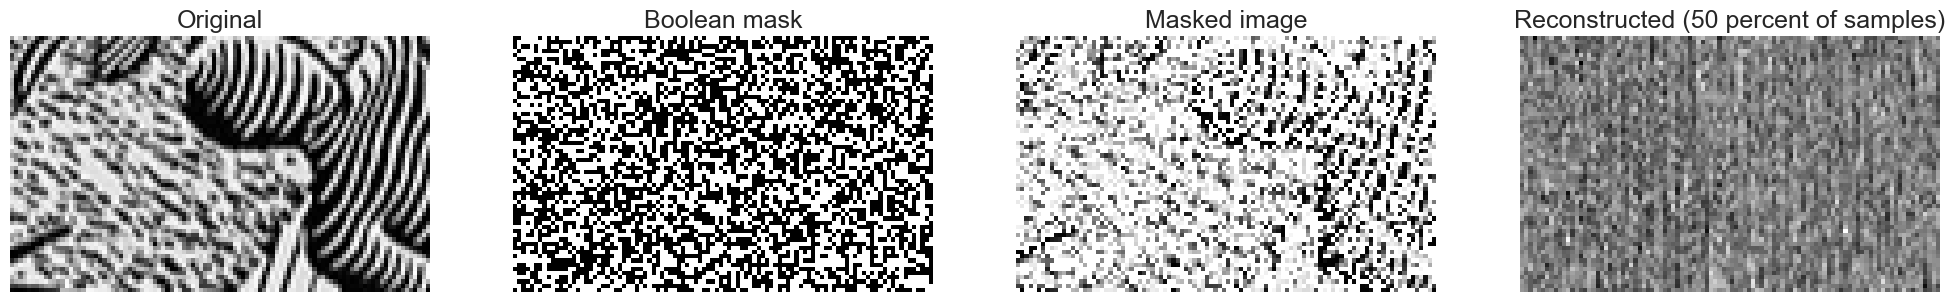

In [33]:
fig,(ax1,ax2,ax3,ax4) = mp.subplots(ncols=4, figsize=(7*2*16/9,7*2))

ax1.imshow(X_slice, cmap="gray", origin="upper")
ax1.set_title(r"Original")
ax1.axis('off')

ax2.imshow(mask, cmap="gray", origin="upper")
ax2.set_title(r"Boolean mask")
ax2.axis('off')

ax3.imshow(Xm, cmap="gray", origin="upper")
ax3.set_title(r"Masked image")
ax3.axis('off')

ax4.imshow(Xa, cmap="gray", origin="upper")
ax4.set_title(r"Reconstructed (%i percent of samples)"%(ex*100))
ax4.axis('off')

mp.show()

In [24]:
slices.shape

(16, 16)

In [21]:
sampslices = []
sampslices.append(X_orig[10, 0]) # horizontal lines
sampslices.append(X_orig[8, 5]) # vertical lines
sampslices.append(X_orig[3, 10]) # diagonal lines
sampslices.append(X_orig[0, 1]) # no obvious pattern
sampslices.append(X_orig[7, 7]) # multiple sinusoids

fig,(ax1,ax2,ax3,ax4,ax5) = mp.subplots(ncols=5, figsize=(7*5*16/9,7))

ax1.imshow(sampslices[0], cmap="gray")
ax1.set_title(r"\textrm{dominant horizontal}")
ax1.axis('off')

ax2.imshow(sampslices[1], cmap="gray")
ax2.set_title(r"\textrm{dominant vertical}")
ax2.axis('off')

ax3.imshow(sampslices[2], cmap="gray")
ax3.set_title(r"\textrm{dominant diagonal}")
ax3.axis('off')

ax4.imshow(sampslices[3], cmap="gray")
ax4.set_title(r"\textrm{no obvious pattern}")
ax4.axis('off')

ax5.imshow(sampslices[4], cmap="gray")
ax5.set_title(r"\textrm{multiple sinusoids}")
ax5.axis('off')

mp.show()

TypeError: Invalid shape () for image data

30% SAMPLES


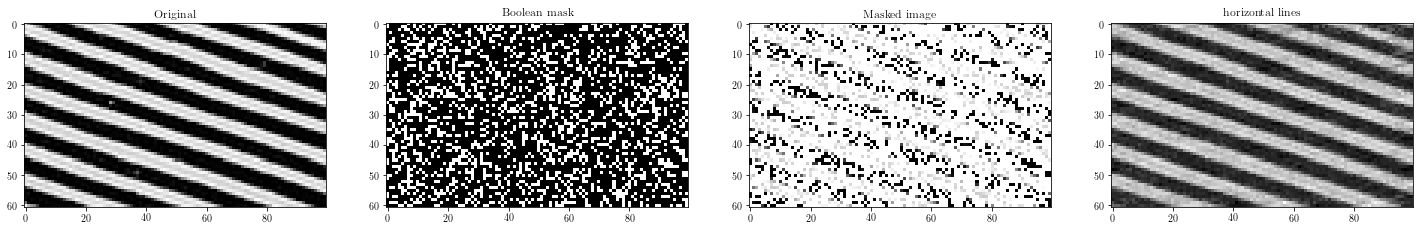

MSE =  479.2983327131561


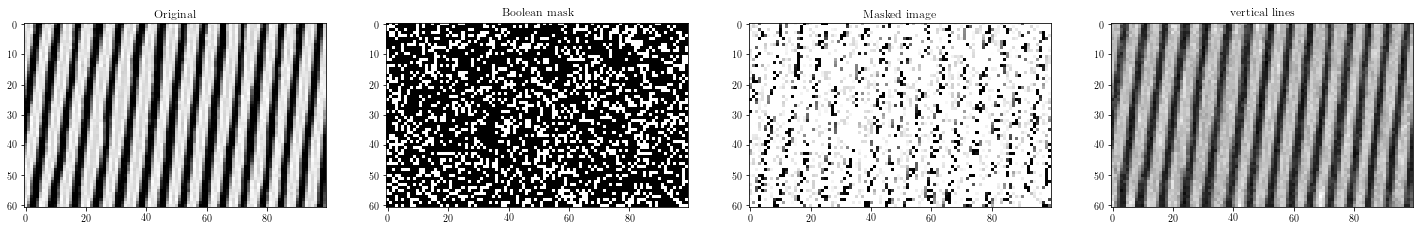

MSE =  588.0708763870024


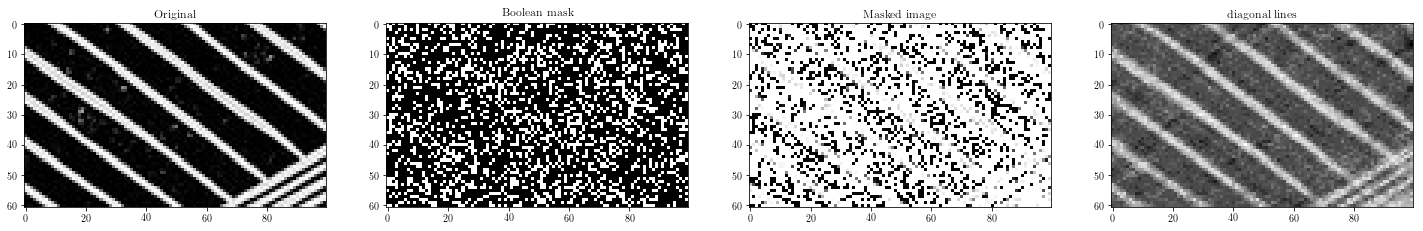

MSE =  1602.6268038603155


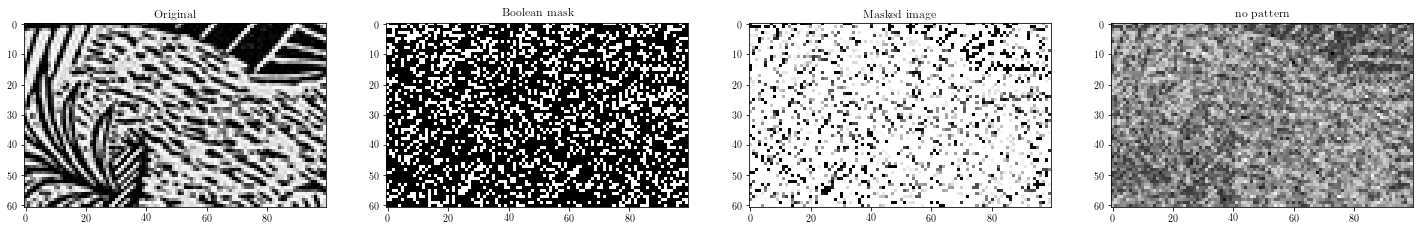

MSE =  7056.399163100747


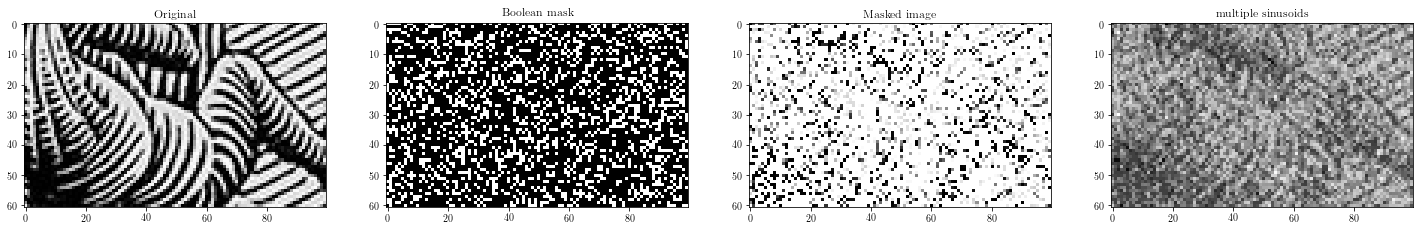

MSE =  7297.769936905055
40% SAMPLES


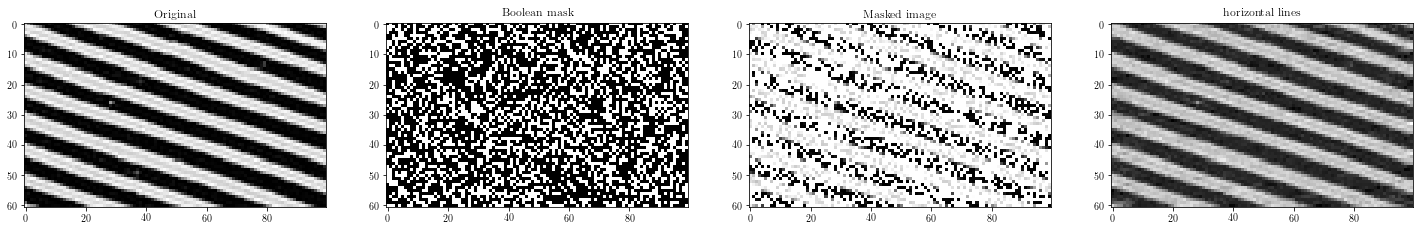

MSE =  301.4830313074483


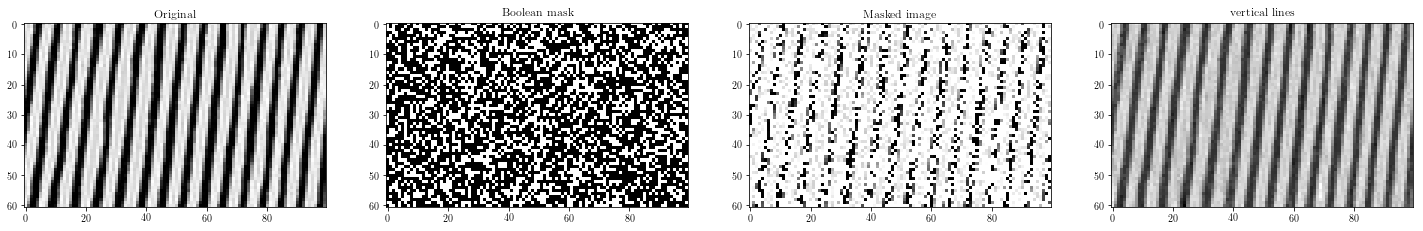

MSE =  328.239936323766


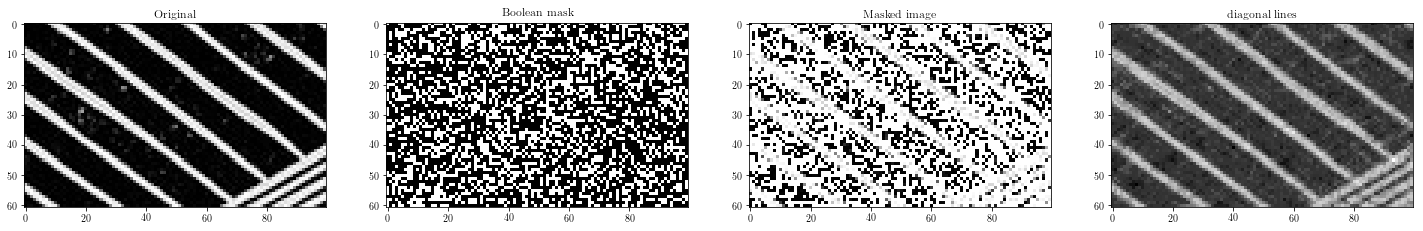

MSE =  814.9522310189172


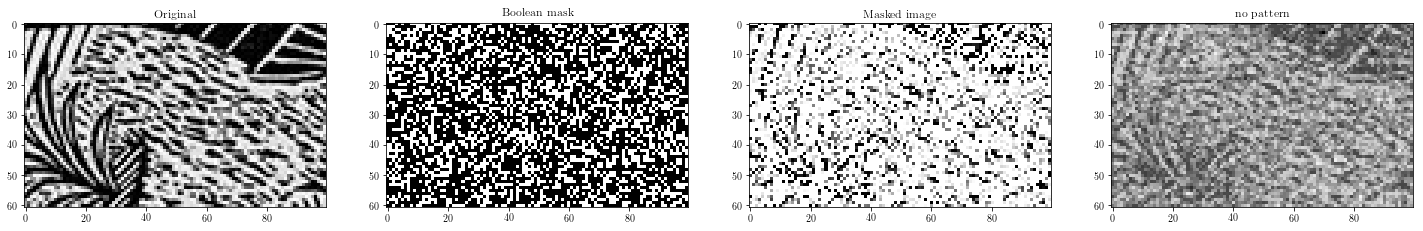

MSE =  5372.1061200056


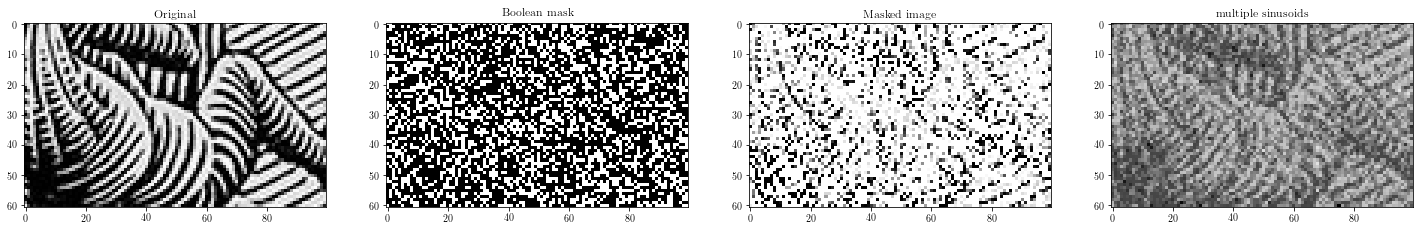

MSE =  5540.1555035241545
50% SAMPLES


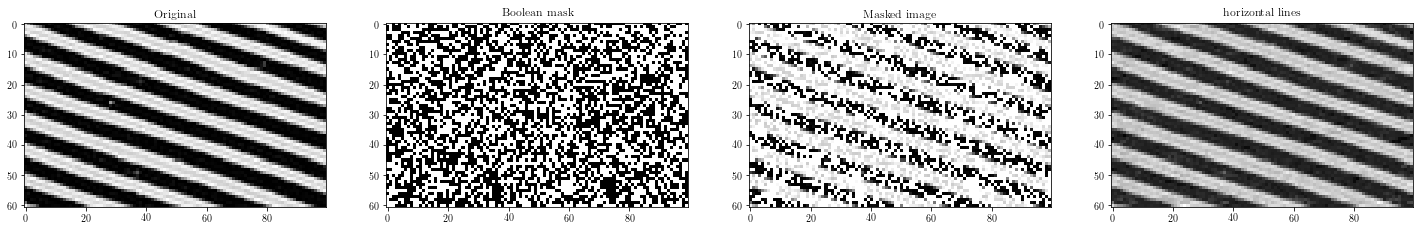

MSE =  188.79714213820273


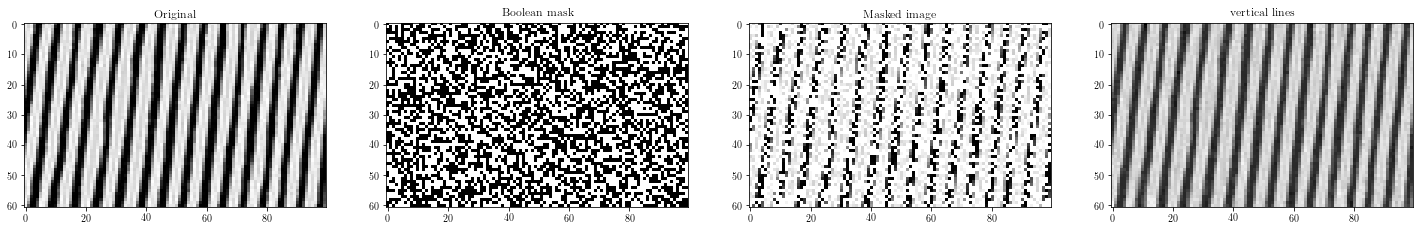

MSE =  159.56882927092212


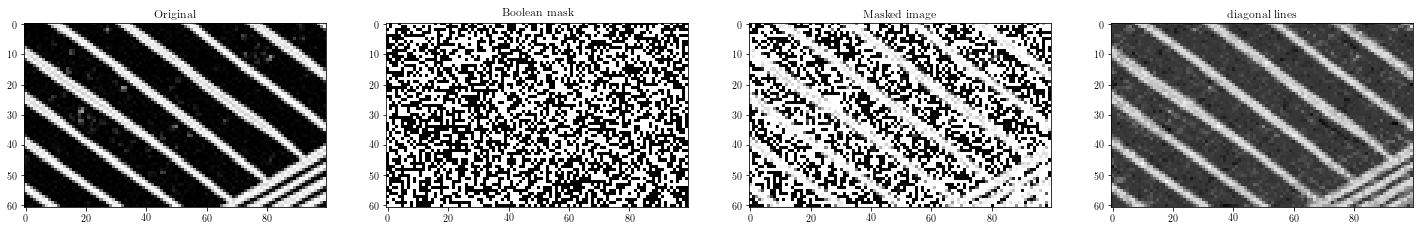

MSE =  560.3078920042051


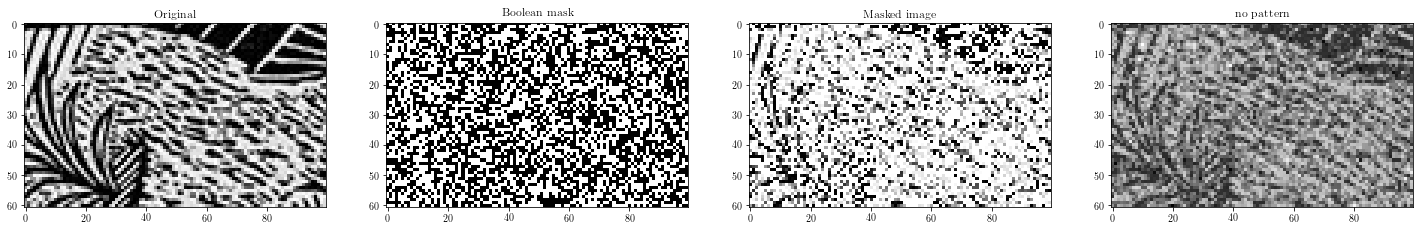

MSE =  4570.296224150872


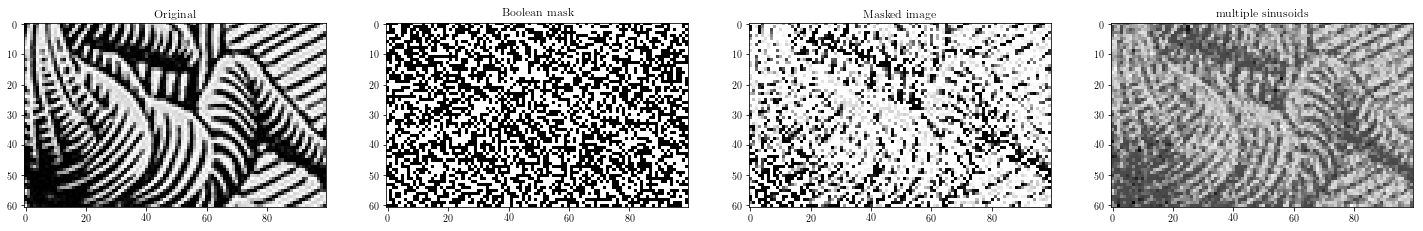

MSE =  4091.737701748826


In [30]:
ex_err = []
for ex in [0.3,0.4,0.5]:
    print("{0}% SAMPLES".format(int(ex*100)))
    samp_err = []
    for i in range(len(sampslices)):
        ny,nx = sampslices[i].shape
        k = np.round(nx * ny * ex).astype(int)
        ri = rd.choice(nx * ny, k, replace=False) # random sample of indices
        b = sampslices[i].T.flat[ri]
        b = np.expand_dims(b, axis=1)

        # create dct matrix operator using kron (memory errors for large ny*nx)
        A = np.kron(fft.idct(np.identity(nx), norm='ortho', axis=0), fft.idct(np.identity(ny), norm='ortho', axis=0))
        A = A[ri,:] # same as phi times kron

        # do L1 optimization
        vx = cvx.Variable(nx * ny)
        objective = cvx.Minimize(cvx.norm(vx, 1))
        constraints = [A*vx == b]
        prob = cvx.Problem(objective, constraints)
        result = prob.solve()
        Xat2 = np.array(vx.value)
        Xat2 = np.squeeze(Xat2)

        Xat = Xat2.reshape(nx, ny).T # stack columns
        Xa = idct2(Xat)

        mask = np.zeros(sampslices[i].shape)
        mask.T.flat[ri] = 255
        Xm = 255 * np.ones(sampslices[i].shape)
        Xm.T.flat[ri] = sampslices[i].T.flat[ri]

        err = skm.mean_squared_error(Xa, sampslices[i])
        samp_err.append(err)

        if i == 0:
            cor = r"\textrm{horizontal lines}"
            fname = "Experiment/2DCS-2/samp" + str(int(ex*100)) + "_horiz.png"
        elif i == 1:
            cor = r"\textrm{vertical lines}"
            fname = "Experiment/2DCS-2/samp" + str(int(ex*100)) + "_vert.png"
        elif i == 2:
            cor = r"\textrm{diagonal lines}"
            fname = "Experiment/2DCS-2/samp" + str(int(ex*100)) + "_diag.png"
        elif i == 3:
            cor = r"\textrm{no pattern}"
            fname = "Experiment/2DCS-2/samp" + str(int(ex*100)) + "_nopatt.png"
        else:
            cor = r"\textrm{multiple sinusoids}"
            fname = "Experiment/2DCS-2/samp" + str(int(ex*100)) + "_mult.png"

        fig,(ax1,ax2,ax3,ax4) = mp.subplots(ncols=4, figsize=(7*2*16/9,7*2))

        ax1.imshow(sampslices[i], cmap="gray", origin="upper")
        ax1.set_title(r"\textrm{Original}")

        ax2.imshow(mask, cmap="gray", origin="upper")
        ax2.set_title(r"\textrm{Boolean mask}")

        ax3.imshow(Xm, cmap="gray", origin="upper")
        ax3.set_title(r"\textrm{Masked image}")

        ax4.imshow(Xa, cmap="gray", origin="upper")
        ax4.set_title(cor)

        mp.savefig(fname, dpi=300, bbox_inches="tight")
        mp.show()

        print("MSE = ", err)
    ex_err.append(samp_err)

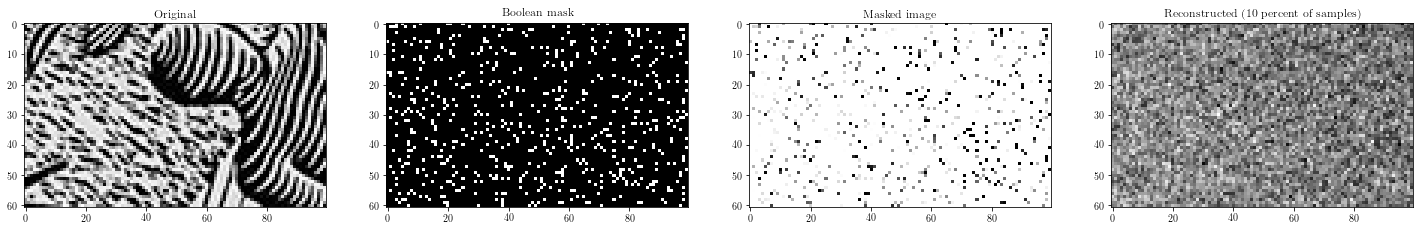

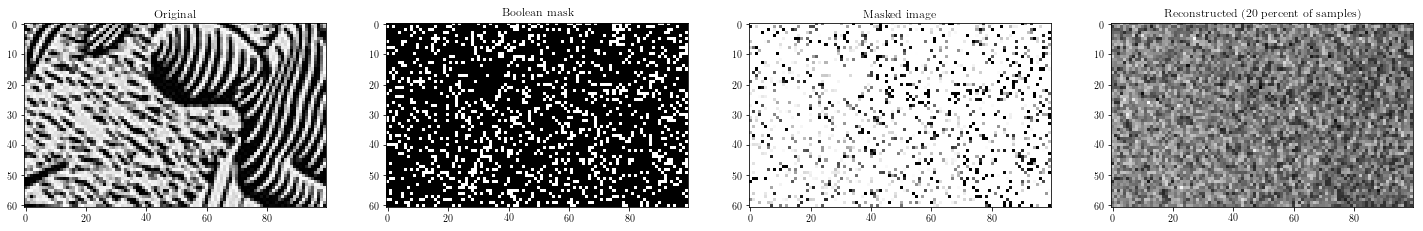

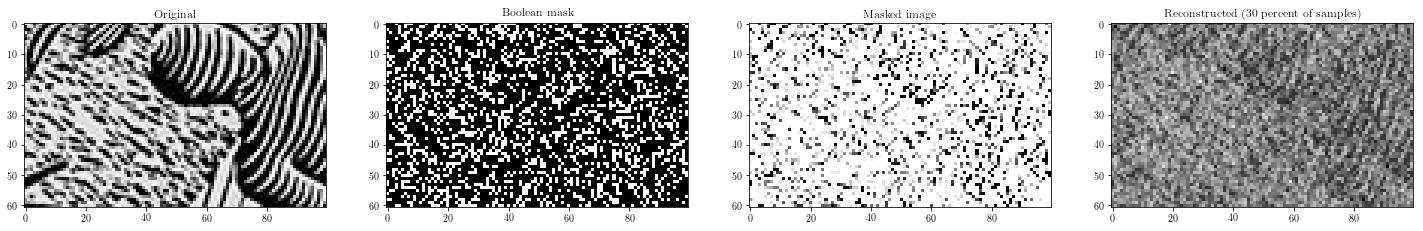

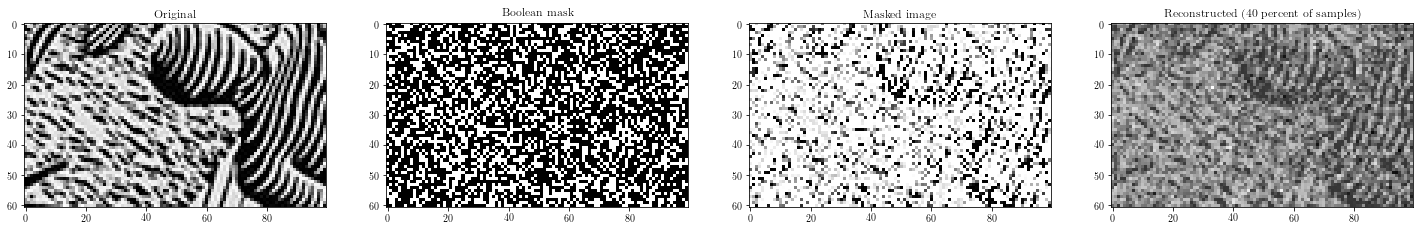

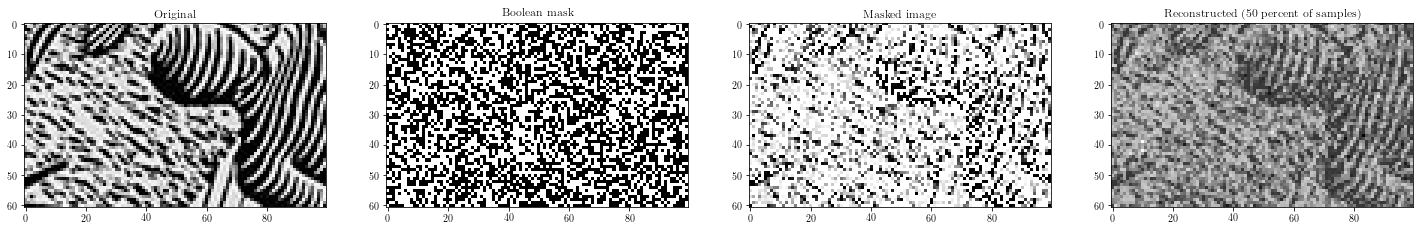

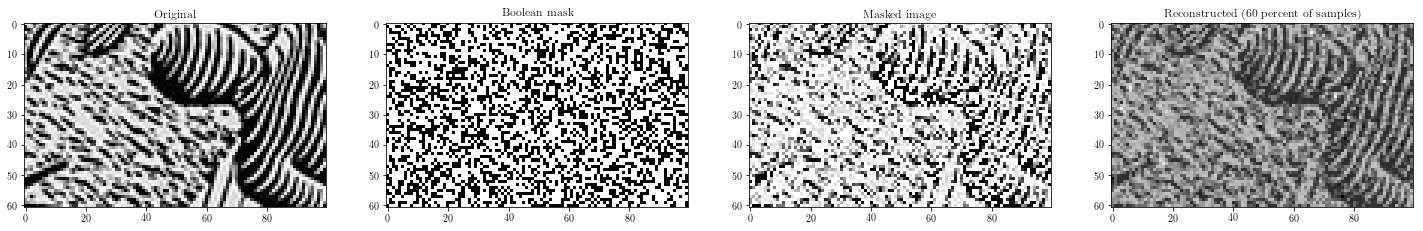

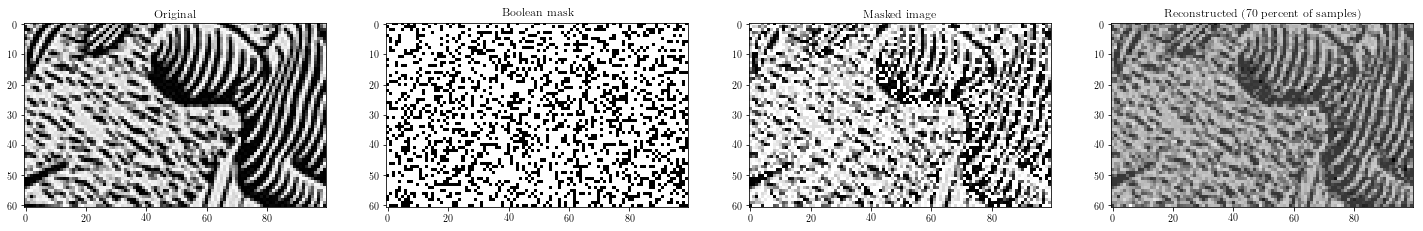

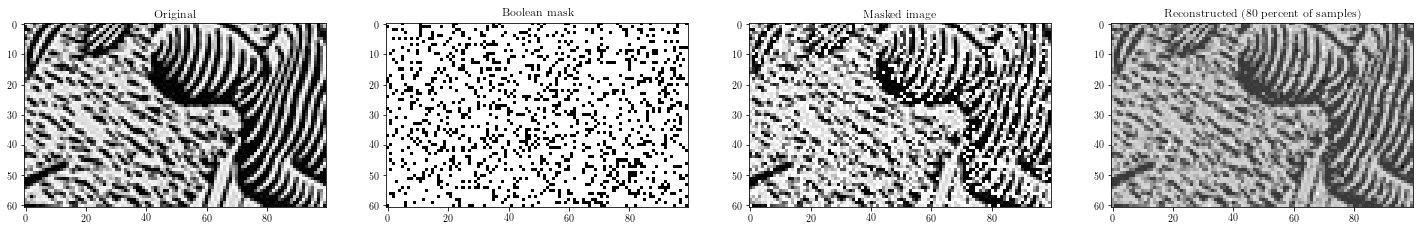

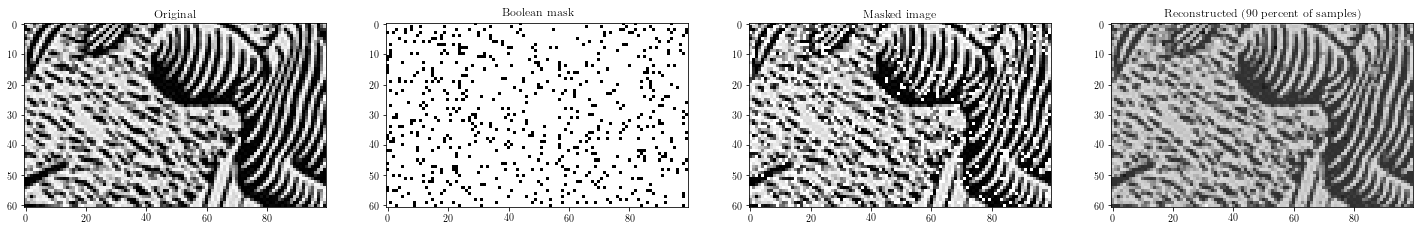

NameError: name 'figsize' is not defined

In [13]:
ny,nx = X_slice.shape

# extract small sample of signal
extract = np.arange(0.1,0.91,0.1)
errlist = []
for ex in extract:
    k = np.round(nx * ny * ex).astype(int)
    ri = rd.choice(nx * ny, k, replace=False) # random sample of indices
    b = X_slice.T.flat[ri]
    b = np.expand_dims(b, axis=1)

    # create dct matrix operator using kron (memory errors for large ny*nx)
    A = np.kron(fft.idct(np.identity(nx), norm='ortho', axis=0), fft.idct(np.identity(ny), norm='ortho', axis=0))
    A = A[ri,:] # same as phi times kron

    # do L1 optimization
    vx = cvx.Variable(nx * ny)
    objective = cvx.Minimize(cvx.norm(vx, 1))
    constraints = [A*vx == b]
    prob = cvx.Problem(objective, constraints)
    result = prob.solve()
    Xat2 = np.array(vx.value)
    Xat2 = np.squeeze(Xat2)

    Xat = Xat2.reshape(nx, ny).T # stack columns
    Xa = idct2(Xat)

    mask = np.zeros(X_slice.shape)
    mask.T.flat[ri] = 255
    Xm = 255 * np.ones(X_slice.shape)
    Xm.T.flat[ri] = X_slice.T.flat[ri]

    errlist.append(skm.mean_squared_error(Xa, X_slice))
    
    fig,(ax1,ax2,ax3,ax4) = mp.subplots(ncols=4, figsize=(7*2*16/9,7*2))

    ax1.imshow(X_slice, cmap="gray", origin="upper")
    ax1.set_title(r"\textrm{Original}")

    ax2.imshow(mask, cmap="gray", origin="upper")
    ax2.set_title(r"\textrm{Boolean mask}")

    ax3.imshow(Xm, cmap="gray", origin="upper")
    ax3.set_title(r"\textrm{Masked image}")

    ax4.imshow(Xa, cmap="gray", origin="upper")
    ax4.set_title(r"\textrm{Reconstructed (%i percent of samples)}"%(ex*100))

    fname = "Experiment/2DCS-1/Xslicemask" + str(int(ex*100)) + ".png"
    mp.savefig(fname, dpi=300, bbox_inches="tight")
    mp.show()

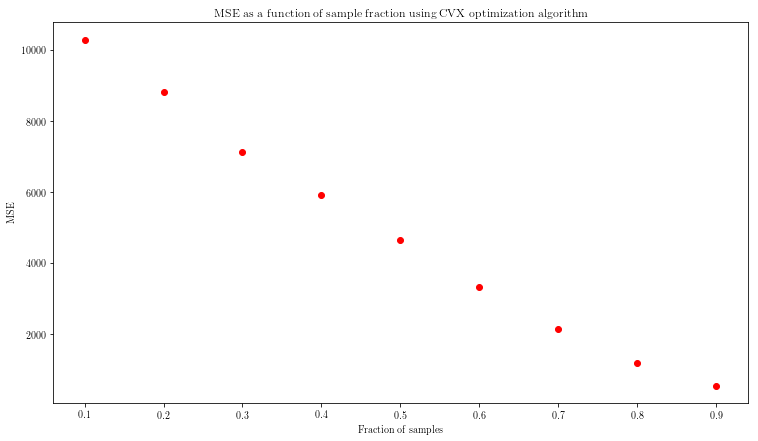

In [16]:
mp.figure(figsize=(7*16/9,7))
mp.plot(extract,errlist, "ro")
mp.xlabel(r"\textrm{Fraction of samples}")
mp.ylabel(r"\textrm{MSE}")
mp.title(r"\textrm{MSE as a function of sample fraction using CVX optimization algorithm}")
mp.savefig("Experiment/2DCS-1/errs.png", dpi=300, bbox_inches="tight")
mp.show()

In [4]:
def evaluate(x, g):
    x2 = x.reshape((nx, ny)).T
    Ax2 = idct2(x2)
    Ax = Ax2.T.flat[ri].reshape(b.shape)
    Axb = Ax - b
    fx = np.sum(np.power(Axb, 2))
    Axb2 = np.zeros(x2.shape)
    Axb2.T.flat[ri] = Axb
    AtAxb2 = 2 * dct2(Axb2)
    AtAxb = AtAxb2.T.reshape(x.shape)
    np.copyto(g, AtAxb)
    return fx

In [5]:
s = 0.1

X = cv.imread("escher_relativity.jpg", 0)
X = cv.resize(X, (1600, 976))
ny, nx = X.shape

Z = np.zeros(X.shape, dtype='uint8')
masks = np.zeros(X.shape, dtype='uint8')

k = round(nx * ny * s)
ri = np.random.choice(nx * ny, k, replace=False)
Xm = 255 * np.ones(X.shape)
Xm.T.flat[ri] = X.T.flat[ri]
masks = Xm
b = X.T.flat[ri].astype(float)
Xat2 = fmin_lbfgs(evaluate, np.ones_like(Xm), orthantwise_c=5)
Xat = Xat2.reshape(nx, ny).T
Xa = idct2(Xat)
Z = Xa.astype('uint8')

d:\kenneth\documents\vip\tf2_env\lib\site-packages\lbfgs\__init__.py:182: UserWarning: When using OWL-QN, 'wolfe' is the only valid line_search. line_search has been set to 'wolfe'.
  warnings.warn("When using OWL-QN, 'wolfe' is the only valid line_search. line_search has been set to 'wolfe'.")


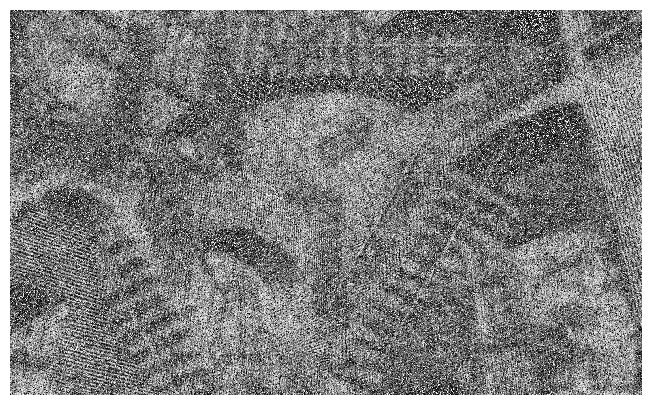

In [7]:
mp.figure(figsize=(5*16/9, 5))
mp.imshow(Z, "gray")
mp.grid(False)
mp.axis('off')
mp.show()